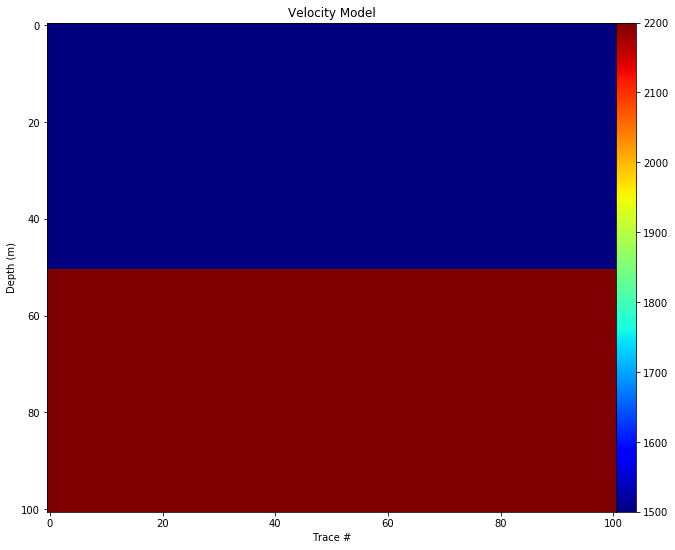

In [110]:
#  https://matplotlib.org/tutorials/colors/colormaps.html
import numpy as np
# Define a velocity model - velocity is in m/s - 100x100 cells
vp = np.empty((101, 101), dtype=np.float32)  #cells start at 1 not zero
vp[:51,:] = 1500.
vp[51:,:] = 2200.

#save the transposed version to ascii format
np.savetxt('velsfile.asc',np.transpose(vp),fmt='%1.7f') 

import subprocess

#convert ascii file to .su file:
# - set ns as number of array depths via suaddhead ns=..
# - set grid spacing via sushw
#a2b <velsfile.asc n1=101 | suaddhead ns=101 | sushw key=dt,d1,d2 a=10000,10,10 >velsfile.su

#convert from .su to .segy file if required...
#segyhdrs <velsfile.su segywrite tape=velsfile.segy



#plot velocity model
fig, axes = plt.subplots(1, 1, figsize=(12, 9))
ax = axes #axes[0]
ax.set_title("Velocity Model")
tmp = ax.imshow(vp, cmap="jet", aspect='auto', origin='upper')
#plt.imshow((vp), cmap='jet', 1aspect=1)
fig.colorbar(tmp, ax=ax, pad=0, aspect=25)
ax.set_xlabel('Trace #')
ax.set_ylabel('Depth (m)')
plt.show()






# Using Bruges

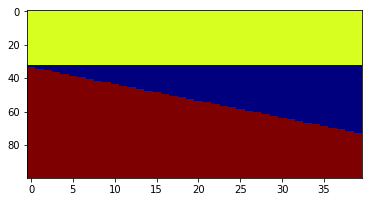

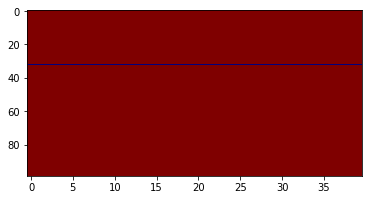

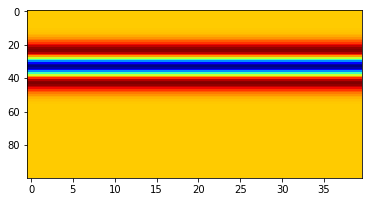

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import bruges
%matplotlib inline

length, depth = 40, 100
model = 1 + np.tri(depth, length, -depth//3)
model[:depth//3,:] = 0
rocks = np.array([[2700, 2750], [2400, 2450], [2800, 3000]])
earth = np.take(rocks, model.astype(int), axis=0)
imp = np.apply_along_axis(np.product, -1, earth)
rc =  (imp[1:,:] - imp[:-1,:]) / (imp[1:,:] + imp[:-1,:])


plt.imshow(imp, cmap='jet', aspect=0.2)
plt.show()
plt.imshow(rc, cmap='jet', aspect=0.2)
plt.show()

w = bruges.filters.ricker(duration=0.100, dt=0.001, f=40)
synth = np.apply_along_axis(lambda t: np.convolve(t, w, mode='same'), axis=0, arr=rc)

plt.imshow(synth, cmap='jet', aspect=0.2)
plt.show()